<a href="https://colab.research.google.com/github/Jejis06/Ai-classifier/blob/master/analiza_zaleznosciowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kod startowy

In [ ]:
ROOT_MODEL_PATH = 'root_model.pth'
DISTANCE_MODEL_PATH = 'distance_model.pth'

In [ ]:
!git clone https://github.com/OlimpiadaAI/I-OlimpiadaAI oai
!mv oai/first_stage/dependency_parsing/* .
!pip install svgling
!pip install sacremoses

fatal: destination path 'oai' already exists and is not an empty directory.
mv: cannot stat 'oai/first_stage/dependency_parsing/*': No such file or directory


In [ ]:
from typing import List

import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from collections import defaultdict
from IPython.display import display
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from transformers import (AutoModel, AutoTokenizer, PreTrainedModel,
                          PreTrainedTokenizer)
from utils import (ListDataset, ParsedSentence, Sentence, merge_subword_tokens,
                   read_conll, uuas_score)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model = AutoModel.from_pretrained("allegro/herbert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/907k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/556k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Herbert

In [ ]:
sentence = "Ala ma kota"
tokenized = tokenizer(
  sentence,
  add_special_tokens=False,
  return_offsets_mapping=True
)
pprint(tokenized)

{'attention_mask': [1, 1, 1, 1],
 'input_ids': [37, 2121, 2185, 24112],
 'offset_mapping': [(0, 1), (1, 3), (4, 6), (7, 11)],
 'token_type_ids': [0, 0, 0, 0]}


In [ ]:
tokenized = tokenizer(
  "Ala ma kota",
  add_special_tokens=True,
  return_offsets_mapping=True
)
pprint(tokenized)

{'attention_mask': [1, 1, 1, 1, 1, 1],
 'input_ids': [0, 37, 2121, 2185, 24112, 2],
 'offset_mapping': [(0, 0), (0, 1), (1, 3), (4, 6), (7, 11), (0, 0)],
 'token_type_ids': [0, 0, 0, 0, 0, 0]}


In [ ]:
tokenized = tokenizer(
  "Ala ma kota",
  return_tensors='pt'
)
model(**tokenized, output_hidden_states=True, return_dict=True)

# Tokenizacja i ekstracja embeddingów

In [ ]:
train_sentences = read_conll('train.conll')  # 1000 zdań
val_sentences = read_conll('valid.conll')  # 200 zdań

Pokój , do którego zaprowadzono gości , miał zaokrąglone wszystkie ściany .


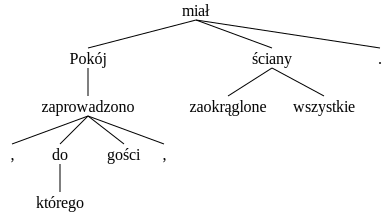

In [ ]:
# TODO: What does this tree represent?
ID = 15
print(train_sentences[ID])
train_sentences[ID].to_tree()  # wyświetl drzewo jednego zdania

In [ ]:
class EmbeddedSentence:
  def __init__(self,
               parsed_sentence: ParsedSentence,
               token_embeddings: List,
               token_ranges: List):
    self.parsed = parsed_sentence
    self.token_embeddings = token_embeddings[1:] # skip first <s>
    self._token_ranges = [(b,e) for b, e in token_ranges if b != 0 or e != 0] # skip <s> and padding
    self.word_embeddings = []
    self._aggregate_word_embeddings()

  def _aggregate_word_embeddings(self):
    word_embeddings = defaultdict(lambda: torch.zeros(768))
    end_of_word = np.cumsum([len(w) + 1 for w in self.parsed.words])
    current_word_id = 0
    for token_id, (b, e) in enumerate(self._token_ranges):
      while b >= end_of_word[current_word_id]:
        current_word_id += 1
      assert e <= end_of_word[current_word_id]
      word_embeddings[current_word_id] += self.token_embeddings[token_id]
    for word_id, _ in enumerate(self.parsed.words):
      self.word_embeddings.append(word_embeddings[word_id])

  def __len__(self):
    return len(self.parsed.words)

In [ ]:
def embed(
    sentences: List[ParsedSentence],
    tokenizer: PreTrainedTokenizer,
    model: PreTrainedModel,
    layer_id=4,
    batch_size = 8,
    show_progress_bar = False
) -> List[EmbeddedSentence]:
    embedded = []
    range_fn = trange if show_progress_bar else range
    for i in range_fn(0, len(sentences), batch_size):
      batch = sentences[i:i+batch_size]
      batch_strings = [' '.join(s.words) for s in batch]
      # Tokenize
      tokens_pt = tokenizer.batch_encode_plus(
          batch_strings,
          padding=True, return_tensors='pt',
          add_special_tokens=True,
          return_offsets_mapping=True)
      # Get embeddings
      with torch.no_grad():
        embeddings = model(input_ids=tokens_pt['input_ids'],
                           token_type_ids=tokens_pt['token_type_ids'],
                           attention_mask=tokens_pt['attention_mask'],
                           output_hidden_states=True, return_dict=True)
      for id in range(len(batch)):
        embedded.append(
            EmbeddedSentence(
                parsed_sentence=batch[id],
                token_embeddings=embeddings['hidden_states'][layer_id][id].squeeze(),
                token_ranges=tokens_pt['offset_mapping'][id]
            )
        )
    return embedded

In [ ]:
sentence = "Ala ma kota a kot ma Alę"
parsed_sentence = ParsedSentence(
    words=sentence.split(),
    heads=[0] + [1] * (len(sentence.split()) - 1)
)

In [ ]:
embedded_sentence = embed(
    [parsed_sentence],
    tokenizer=tokenizer,
    model=model,
    layer_id=4
)[0]

In [ ]:
embedded_sentence.word_embeddings[0].size()

torch.Size([768])

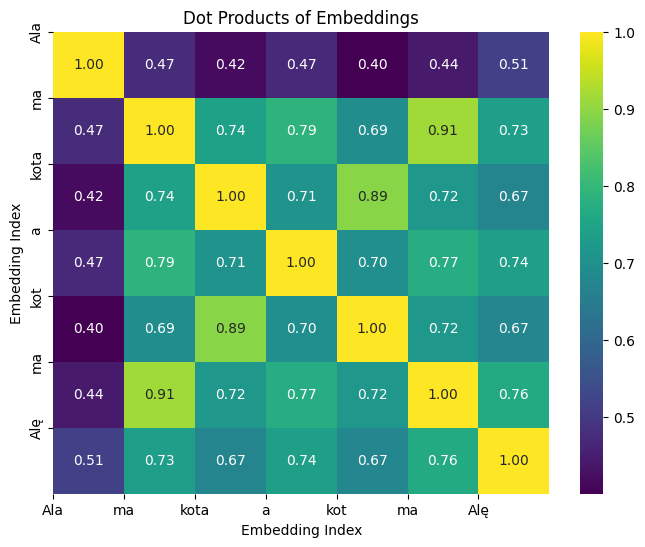

In [ ]:
def display_embedding_heatmap(sentence : EmbeddedSentence):
    embeddings = sentence.word_embeddings
    dot_products = np.zeros((len(embeddings), len(embeddings)))
    for i, j in itertools.product(range(len(embeddings)), repeat=2):
        dot_products[i, j] = np.dot(embeddings[i], embeddings[j]) / embeddings[i].norm() / embeddings[j].norm()

    plt.figure(figsize=(8, 6))
    sns.heatmap(dot_products, annot=True, cmap="viridis", fmt=".2f")
    plt.xticks(
        ticks=range(len(sentence.parsed.words)),
        labels=sentence.parsed.words)
    plt.yticks(
        ticks=range(len(sentence.parsed.words)),
        labels=sentence.parsed.words)
    plt.title("Dot Products of Embeddings")
    plt.xlabel("Embedding Index")
    plt.ylabel("Embedding Index")
    plt.show()

display_embedding_heatmap(embedded_sentence)

In [ ]:
layer_id = 11
embedded_train_sentences = embed(train_sentences,
                                 tokenizer=tokenizer,
                                 model=model,
                                 layer_id=layer_id,
                                 batch_size=4,
                                 show_progress_bar=True)
embedded_val_sentences = embed(val_sentences,
                               tokenizer=tokenizer,
                               model=model,
                               batch_size=4,
                               layer_id=layer_id,
                               show_progress_bar=True)

 39%|███▉      | 98/250 [01:04<01:47,  1.41it/s]

# Root dataset

In [ ]:
class RootDataset(Dataset):
  def __init__(self, embedded_sentences):
    self.embedded_sentences = embedded_sentences
    self.num_samples_per_sentences = lambda e: len(e)
    self.total_num_samples = sum([self.num_samples_per_sentences(e) for e in embedded_sentences])
    self.sample_id_to_sentence_id = dict(zip(
        range(self.total_num_samples),
        itertools.chain(*[
            list(enumerate([id] * self.num_samples_per_sentences(e))) for id, e in enumerate(self.embedded_sentences)
        ])
    ))

  def __len__(self):
    return self.total_num_samples

  def __getitem__(self, sample_id):
    word_id, sentence_id = self.sample_id_to_sentence_id[sample_id]
    sentence = self.embedded_sentences[sentence_id]
    word_embedding = sentence.word_embeddings[word_id]
    return word_embedding, word_id == sentence.parsed.root # (embedding, is_root?)

In [ ]:
def validate_model(*, model, val_dataset):
  # TODO: Do we measure what we want?
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
  model.eval()
  all_outputs = []
  all_targets = []
  with torch.no_grad():
    for batch in val_loader:
      inputs, target, *_ = batch
      outputs = model(inputs).squeeze()
      all_outputs.extend(outputs.numpy().tolist())
      all_targets.extend(target.numpy().tolist())
  num_correct = np.sum(np.round(all_outputs) == all_targets)
  return num_correct / len(all_targets), all_outputs, all_targets

In [ ]:
def train_model(*, model,
                train_dataset,
                val_dataset,
                learning_rate,
                loss_fn,
                num_epochs,
                batch_size=32,
                validate_fn=validate_model):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in tqdm(train_loader):
            inputs, target, *_ = batch

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, target.float())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        val_score, *_ = validate_fn(model=model, val_dataset=val_dataset)
        print(f"Epoch [{epoch + 1}/{num_epochs}]",
              f"Training loss: {avg_loss:.4f}",
              f"Validation score: {val_score:.3f}")

# Root model

In [ ]:
class RootModel(torch.nn.Module):
    def __init__(self, input_dim=768):
      # TODO: Add a new hidden layer. Does it improve the validation score?
      # If you add more layers, remember to call torch.relu(...) to add non-linearities.
      super(RootModel, self).__init__()
      self.linear1 = nn.Linear(input_dim, 1)

    def forward(self, x):
      x = self.linear1(x)
      return torch.sigmoid(x)

In [58]:
print("Training root model")
# TODO: Play around with the parameters
root_model = RootModel(input_dim=768)
train_model(
    model=root_model,
    train_dataset=RootDataset(embedded_train_sentences),
    val_dataset=RootDataset(embedded_val_sentences),
    loss_fn=nn.BCELoss(),
    learning_rate=0.1,
    num_epochs=10,
    validate_fn=validate_model
)

Training root model


100%|██████████| 302/302 [00:01<00:00, 250.35it/s]


Epoch [1/10] Training loss: 0.5516 Validation score: 0.949


100%|██████████| 302/302 [00:00<00:00, 370.81it/s]


Epoch [2/10] Training loss: 0.5271 Validation score: 0.941


100%|██████████| 302/302 [00:00<00:00, 582.38it/s]


Epoch [3/10] Training loss: 0.6957 Validation score: 0.957


100%|██████████| 302/302 [00:00<00:00, 428.45it/s]


Epoch [4/10] Training loss: 0.5677 Validation score: 0.962


100%|██████████| 302/302 [00:00<00:00, 431.78it/s]


Epoch [5/10] Training loss: 0.4382 Validation score: 0.962


100%|██████████| 302/302 [00:00<00:00, 555.03it/s]


Epoch [6/10] Training loss: 0.5929 Validation score: 0.928


100%|██████████| 302/302 [00:00<00:00, 528.13it/s]


Epoch [7/10] Training loss: 0.6426 Validation score: 0.955


100%|██████████| 302/302 [00:00<00:00, 510.32it/s]


Epoch [8/10] Training loss: 0.5188 Validation score: 0.958


100%|██████████| 302/302 [00:00<00:00, 478.11it/s]


Epoch [9/10] Training loss: 0.6892 Validation score: 0.960


100%|██████████| 302/302 [00:01<00:00, 290.13it/s]


Epoch [10/10] Training loss: 0.6361 Validation score: 0.957


In [59]:
# zapisz wagi modelu do pliku
torch.save(root_model.state_dict(), ROOT_MODEL_PATH)

In [62]:
def print_classified_examples(*, model, val_dataset, print_correct, num_examples):
  model.eval()
  with torch.no_grad():
    for sentence in val_dataset.embedded_sentences:
      inputs = torch.stack([e for e in sentence.word_embeddings])
      outputs = model(inputs).squeeze().numpy()
      correct = (np.argmax(outputs) == sentence.parsed.root)
      if correct == print_correct:
        s = ' '.join(sentence.parsed.words)
        root_target = sentence.parsed.words[sentence.parsed.root]
        root_prediction = sentence.parsed.words[np.argmax(outputs)]
        display_embedding_heatmap(sentence)
        print(f"PRAW: {outputs}\n|{s} | Correct: {root_target} Prediction: {root_prediction}\n\n")
        num_examples -= 1
        if num_examples == 0:
          return

In [63]:
print_classified_examples(
    model=root_model,
    val_dataset=RootDataset(embedded_val_sentences),
    print_correct=False,
    num_examples=10
)

PRAW: [0.00000000e+00 1.70151442e-01 1.00000000e+00 1.00000000e+00
 2.17712119e-38 1.05862884e-26 3.31312035e-24 7.47868087e-11]
|Ty jutro wyjeżdżasz , ja tu zostaję . | Correct: , Prediction: wyjeżdżasz


PRAW: [1.4461320e-38 9.5622867e-01 9.8781464e-05 2.1204344e-23 7.7300311e-22]
|Stan rannych jest stabilny . | Correct: jest Prediction: rannych


PRAW: [1.7267952e-25 1.3481629e-01 5.4570365e-01 1.1131313e-24 1.5607792e-14
 1.8495892e-15 1.2185168e-10]
|Teraz wystarczy na dwa razy więcej . | Correct: wystarczy Prediction: na


PRAW: [5.3624776e-34 1.0024621e-01 1.0000000e+00 0.0000000e+00 0.0000000e+00
 1.5447723e-28 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
 0.0000000e+00 2.0490276e-11 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.7244363e-20]
|Z lodówki wyjęła niewielki dozownik wypełniony rubinową cieczą i bardzo ostrożnie wcisnęła go do otworu w pudełku . | Correct: i Prediction: wyjęła


PRAW: [1.1463007e-14 1.7045556e-01 8.2602242e-27 2.

# Distance dataset

In [ ]:
class DistanceDataset(Dataset):
  def __init__(self, embedded_sentences):
    self.embedded_sentences = embedded_sentences
    self.num_samples_per_sentences = lambda s: len(s.parsed.get_sorted_edges()) * 2 # (a, b) and random
    self.total_num_samples = sum([self.num_samples_per_sentences(e) for e in embedded_sentences])
    self.sample_id_to_sentence_id = dict(zip(
        range(self.total_num_samples),
        itertools.chain(*[
            list([id] * self.num_samples_per_sentences(e)) for id, e in enumerate(self.embedded_sentences)
        ])
    ))

  def __len__(self):
    return self.total_num_samples

  def __getitem__(self, sample_id):
    sentence_id = self.sample_id_to_sentence_id[sample_id]
    sentence = self.embedded_sentences[sentence_id]
    sentence_edges = sentence.parsed.get_sorted_edges()
    num_edges = len(sentence_edges)
    if sample_id % 2 == 0:
      edge = sentence_edges[np.random.choice(num_edges)]
      target = 1
    else:
      edge = sentence_edges[0]
      while edge in sentence.parsed.get_sorted_edges():
        edge = tuple(np.random.choice(len(sentence.parsed.words), size=(2,), replace=False))
      target = 0
    return torch.cat([sentence.word_embeddings[edge[0]],
                      sentence.word_embeddings[edge[1]]], dim=-1), target

In [ ]:
class DistanceModel(torch.nn.Module):
    def __init__(self, input_dim=768):
        super(DistanceModel, self).__init__()
        self.input_dim = input_dim
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 1)

    def forward(self, xy):
      x = xy[..., :self.input_dim]
      y = xy[..., self.input_dim:]
      act1 = torch.relu(self.linear1(x - y))
      return torch.sigmoid(self.linear2(act1))

In [ ]:
distance_model = DistanceModel(input_dim=768)
train_model(model=distance_model,
            train_dataset=DistanceDataset(embedded_train_sentences),
            val_dataset=DistanceDataset(embedded_val_sentences),
            learning_rate=0.001,
            loss_fn=nn.BCELoss(),
            num_epochs=3)

100%|██████████| 542/542 [00:03<00:00, 153.42it/s]


Epoch [1/3] Training loss: 0.4131 Validation score: 0.867


100%|██████████| 542/542 [00:06<00:00, 86.11it/s] 


Epoch [2/3] Training loss: 0.2732 Validation score: 0.896


100%|██████████| 542/542 [00:02<00:00, 240.73it/s]


Epoch [3/3] Training loss: 0.2269 Validation score: 0.899


In [ ]:
# zapisz wagi modelu do pliku
torch.save(distance_model.state_dict(), DISTANCE_MODEL_PATH)

In [ ]:
def pick_tree_edges(sentence: EmbeddedSentence, distance_model: DistanceModel):
  # TODO: Zwróć listę krawędzi

----------
Wytrenowany model:
----------


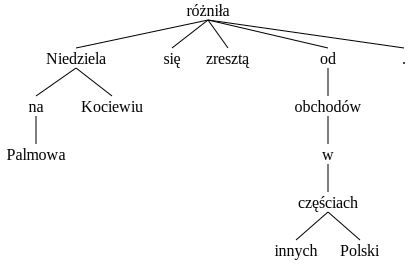

----------
Wzorcowe drzewo:
----------


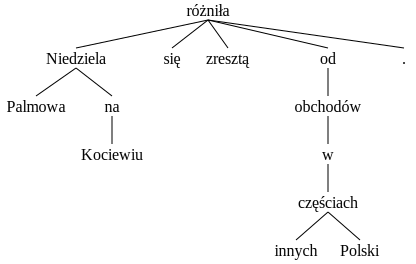

In [ ]:
SID = 43
sentence = embedded_train_sentences[SID]

print("-" * 10)
print("Wytrenowany model:")
print("-" * 10)
display(ParsedSentence.from_edges_and_root(
    sentence.parsed.words,
    edges=pick_tree_edges(sentence, distance_model),
    root=sentence.parsed.root).to_tree())
print("-" * 10)
print("Wzorcowe drzewo:")
print("-" * 10)
display(sentence.parsed.to_tree())

# Ewaluacja
Kod bardzo podobny do poniższego będzie służył do ewaluacji rozwiązania na zdaniach testowych. Wywołując poniższe komórki możesz dowiedzieć się ile punktów zdobyłoby twoje rozwiązanie, gdybyśmy ocenili je na danych walidacyjnych. Przed wysłaniem rozwiązania upewnij się, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [ ]:
def parse_sentence(parsed_sentence: ParsedSentence, distance_model, root_model, tokenizer, model) -> ParsedSentence:
    """Zbuduj drzewo składniowe dla pojedynczego zdania.

    Argumenty:
        sent: Zdanie do sparsowania.
        distance_model: Wytrenowany model odległości
        root_model: Wytrenowany model głębokości
        tokenizer: Tokenizator HERBERT
        model: Model HERBERT

    Zwraca:
        ParsedSentence: Zdanie z przewidzianym drzewem składniowym.

    """

    with torch.no_grad():
      embedded_sentence = embed([parsed_sentence],  tokenizer=tokenizer, model=model)[0]
      root_scores = [float(root_model(e)) for e in embedded_sentence.word_embeddings]
      root_word_id = np.argmax(root_scores)
      tree_edges = pick_tree_edges(embedded_sentence, distance_model)
      return ParsedSentence.from_edges_and_root(
          parsed_sentence.words,
          edges=tree_edges,
          root=root_word_id
      )



In [ ]:
SID = 1
sentence = train_sentences[SID]
embedded_sentence = parse_sentence(sentence, distance_model, root_model, tokenizer, model)
print("--")
embedded_sentence.pretty_print()  # Przewidziane drzewo
sentence.pretty_print()  # Złote drzewo (ze zbioru danych)

--
                                i                          
  ______________________________|______________             
 |               podawane                      |           
 |        __________|___________               |            
 |       |         Przy         |            zależy        
 |       |          |           |          ____|_______     
 |       |      kredytach       |         |    |       od  
 |       |          |           |         |    |       |    
 |       |         dla         jest       |    z     oceny 
 |       |          |           |         |    |       |    
 .  najczęściej  ludności oprocentowanie nie  góry  klienta

                                  i                                      
       ___________________________|__________________________             
      |         |     Przy                  |              zależy        
      |         |      |                    |            ____|_______     
      |         |  kredytach     

In [ ]:
def points(root_placement, uuas):
    def scale(x, lower=0.5, upper=0.85):
        scaled = min(max(x, lower), upper)
        return (scaled - lower) / (upper - lower)
    return (scale(root_placement) + scale(uuas))

def evaluate_model(sentences: List[ParsedSentence], distance_model, depth_model, tokenizer, model):
    sum_uuas = 0
    root_correct = 0
    with torch.no_grad():
        for sent in tqdm(sentences):
            parsed = parse_sentence(sent, distance_model, depth_model, tokenizer, model)
            root_correct += int(parsed.root == sent.root)
            sum_uuas += uuas_score(sent, parsed)

    root_placement = root_correct / len(sentences)
    uuas = sum_uuas / len(sentences)

    print(f"UUAS: {uuas * 100:.3}%")
    print(f"Root placement: {root_placement * 100:.3}%")
    print(f"Your score: {points(root_placement, uuas):.1}/2.0")

In [ ]:
if not FINAL_EVALUATION_MODE:
    distance_model_loaded = DistanceModel()
    distance_model_loaded.load_state_dict(torch.load(DISTANCE_MODEL_PATH))

    root_model_loaded = RootModel()
    root_model_loaded.load_state_dict(torch.load(ROOT_MODEL_PATH))

    evaluate_model(val_sentences, distance_model_loaded, root_model_loaded, tokenizer, model)

<ipython-input-133-d2605052ba34>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  distance_model_loaded.load_state_dict(torch.load(DISTANCE_MODEL_PATH))
<ipython-input-133-d

UUAS: 82.6%
Root placement: 84.0%
Your score: 2e+00/2.0


# Appendix

{'input_ids': [0, 37, 2121, 2185, 2], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
tokens = tokenizer("Ala ma", return_tensors='pt')
tokens

{'input_ids': tensor([[   0,   37, 2121, 2185,    2]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [ ]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(50000, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
with torch.no_grad():
  output = decoder( input_ids=tokens['input_ids'],
                      # token_type_ids=tokens['token_type_ids'],
                      # attention_mask=tokens['attention_mask'],
                      # output_hidden_states=True,
                      # return_dict=True
                    )
type(output)

transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions

In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained("allegro/herbert-base-cased")
print(config)

BertConfig {
  "_name_or_path": "allegro/herbert-base-cased",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 514,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "HerbertTokenizerFast",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50000
}



In [ ]:
output = model(
    **tokenizer.batch_encode_plus(
        [
            (
                "A potem szedł środkiem drogi w kurzawie, bo zamiatał nogami, ślepy dziad prowadzony przez tłustego kundla na sznurku.",
                "A potem leciał od lasu chłopak z butelką, ale ten ujrzawszy księdza przy drodze okrążył go z dala i biegł na przełaj pól do karczmy."
            )
        ],
        padding="longest",
        add_special_tokens=True,
        return_tensors="pt",
    )
)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])